In [ ]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.9.2


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename ='/content/drive/MyDrive/korean_lotto_3.csv'
lotto = pd.read_csv(filename)
print(lotto)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      Ball_1  Ball_2  Ball_3  Ball_4  Ball_5  Ball_6  Ball_Bonus
0         10      23      29      33      37      40          16
1          9      13      21      25      32      42           2
2         11      16      19      21      27      31          30
3         14      27      30      31      40      42           2
4         16      24      29      40      41      42           3
...      ...     ...     ...     ...     ...     ...         ...
998        1       3       9      14      18      28          34
999        2       8      19      22      32      42          39
1000       6      10      12      14      20      42          15
1001      17      25      33      35      38      45          15
1002       1       4      29      39      43      45          31

[1003 rows x 7 columns]


In [ ]:
data = lotto.values - 1 
train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [ ]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1003, 7)
(943, 10, 7)
(943, 7)
(50, 10, 7)
(50, 7)


In [ ]:
embed_dim = (59 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [ ]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(59, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(59, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(59, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(59, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(59, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(59, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(59, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
       
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(59, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                              

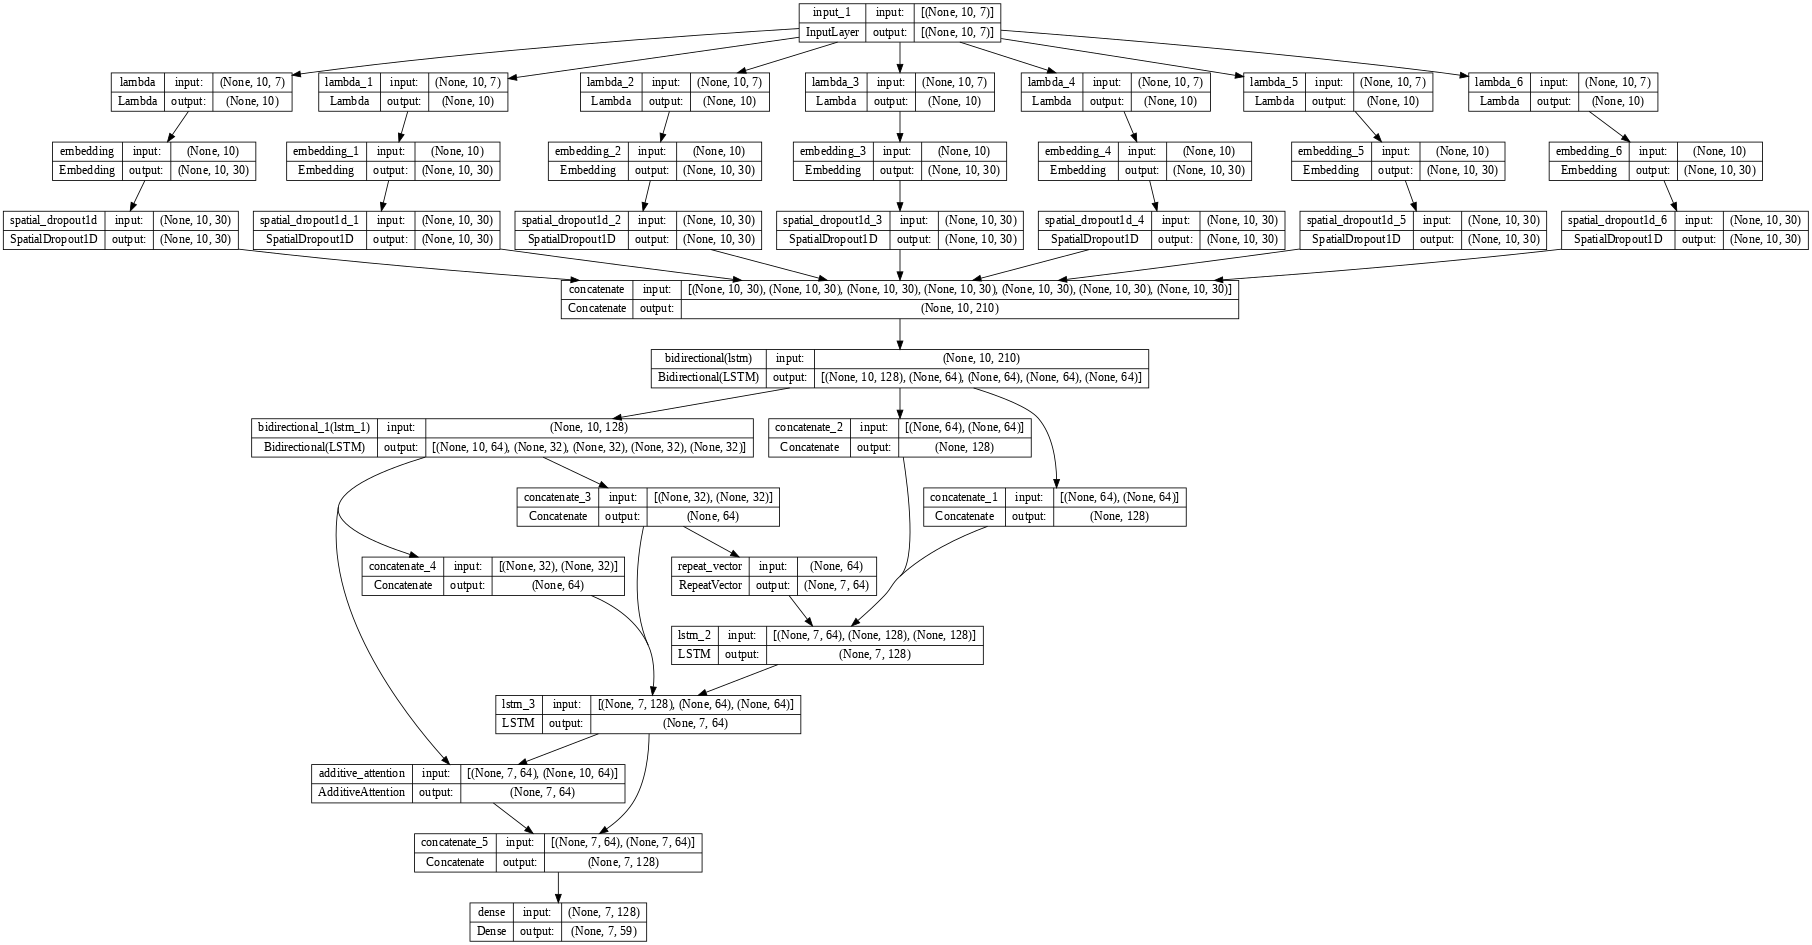

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [ ]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [ ]:
EPOCHS = 200
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/200
30/30 - 17s - loss: 4.0748 - sparse_top_k: 0.1085 - val_loss: 4.0723 - val_sparse_top_k: 0.1371 - lr: 1.0000e-04 - 17s/epoch - 580ms/step
Epoch 2/200
30/30 - 2s - loss: 4.0677 - sparse_top_k: 0.1345 - val_loss: 4.0625 - val_sparse_top_k: 0.1171 - lr: 9.9994e-05 - 2s/epoch - 60ms/step
Epoch 3/200
30/30 - 2s - loss: 4.0495 - sparse_top_k: 0.1421 - val_loss: 4.0298 - val_sparse_top_k: 0.1314 - lr: 9.9978e-05 - 2s/epoch - 59ms/step
Epoch 4/200
30/30 - 2s - loss: 3.9743 - sparse_top_k: 0.1482 - val_loss: 3.9075 - val_sparse_top_k: 0.1257 - lr: 9.9950e-05 - 2s/epoch - 57ms/step
Epoch 5/200
30/30 - 2s - loss: 3.8478 - sparse_top_k: 0.1521 - val_loss: 3.7793 - val_sparse_top_k: 0.1457 - lr: 9.9911e-05 - 2s/epoch - 64ms/step
Epoch 6/200
30/30 - 2s - loss: 3.7263 - sparse_top_k: 0.1956 - val_loss: 3.6544 - val_sparse_top_k: 0.1886 - lr: 9.9861e-05 - 2s/epoch - 60ms/step
Epoch 7/200
30/30 - 2s - loss: 3.6408 - sparse_top_k: 0.2235 - val_loss: 3.5923 - val_sparse_top_k: 0.2200 - lr: 9.

0.334285706281662


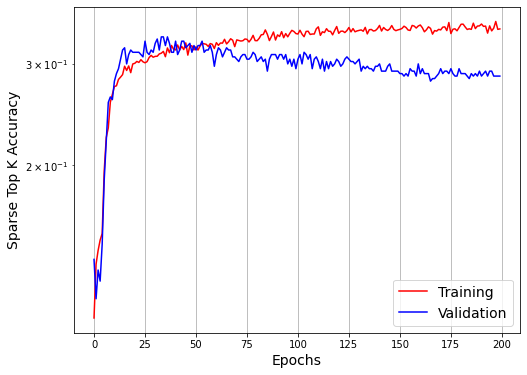

In [ ]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2/2 [==============================] - 3s 16ms/step


In [ ]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 1  9 26 28 30 41 32]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 4  9 23 26 29 33  8]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [10 11 20 21 25 41 40]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 4 15 24 35 36 40  1]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 2  9 10 16 35 37  1]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 1 14 15 24 40 41 35]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 2 18 24 30 32 45 14]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [11 20 29 31 33 42 43]
----------------------------------------
Prediction:	 [ 1 10 18 27 34 43 43]
GoundTruth:	 [ 1 18 28 31 34 43 40]
------------------------